In [1]:
from easydict import EasyDict
from transformers import BertTokenizer
from transformer.transformer import *
import math
from util.generate import *
from pretrain import *
from text_color import *
from text_color_data import *
from img_shape import *
from img_shape_data import *
from img_text import *
from img_text_data import *
from img_graph import *
from img_graph_data import *
import random

c:\Users\singbhang\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\singbhang\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
data_dir = pathlib.Path('.').absolute() / 'data'
train_aug_dir = data_dir / 'train_augmented'
train_aug_img_dir = train_aug_dir / 'images'
train_graph_aug_dir = data_dir / 'train_graph_augmented'
valid_dir = data_dir / 'valid'
valid_img_dir = valid_dir / 'images'
model_folder = pathlib.Path('.').absolute() / 'model'

# Image -> Shape

In [3]:
ie = ImageEncoder(
    input_resolution=256,
    patch_size=24,
    hidden_dim=128,
    intermediate_dim=128*4,
    head_num=8,
    block_num=8,
    drop_rate=0.1,
    ln_eps=1e-5
)
model = Img2Shape.load_from_checkpoint(
    model_folder / 'img2shape/Img2Shape-epoch=49.ckpt',
    img_encoder = ie
)
dm = ImgShapeDataModule(
    batch_size=10,
    train_path=train_aug_dir,
    valid_path=valid_dir
)
dm.setup()

In [4]:
# disable grads + batchnorm + dropout
model = model.to('cpu')

torch.set_grad_enabled(False)
model.eval()
pos_lst = []
neg_lst = []

for idx in range(1500):
# for idx in random.choices(range(1500), k=10):
    img, target = dm.validation_dataset[idx]
    img = img.to(model.device)
    img = img.unsqueeze(dim=0) # batch 형태로 변환
    pred = model(img)
    pred = F.sigmoid(pred)
    # print('[%s]' % idx)
    print('prediction:', pred)
    print('target:', target)

    for i in torch.flatten(target * pred):
        if i > 0:
            pos_lst.append(i)
    for i in torch.flatten(torch.logical_not(target).int() * pred):
        if i > 0:
            neg_lst.append(i)

prediction: tensor([[0.3798, 0.4187, 0.9684, 0.9721, 0.0149]])
target: tensor([1., 0., 1., 1., 0.])
prediction: tensor([[0.0960, 0.0495, 0.9073, 0.9332, 0.9030]])
target: tensor([0., 0., 1., 1., 1.])
prediction: tensor([[0.1264, 0.7092, 0.7878, 0.9759, 0.0164]])
target: tensor([0., 1., 0., 1., 0.])
prediction: tensor([[0.1247, 0.6009, 0.9515, 0.9612, 0.0206]])
target: tensor([0., 1., 1., 1., 0.])
prediction: tensor([[0.0770, 0.1049, 0.9465, 0.9581, 0.0579]])
target: tensor([0., 0., 1., 1., 0.])
prediction: tensor([[0.8642, 0.6375, 0.0096, 0.9357, 0.0707]])
target: tensor([0., 1., 0., 1., 1.])
prediction: tensor([[0.8947, 0.2647, 0.0518, 0.0338, 0.9419]])
target: tensor([1., 0., 0., 0., 1.])
prediction: tensor([[0.2830, 0.8238, 0.0276, 0.9701, 0.0508]])
target: tensor([0., 1., 0., 1., 0.])
prediction: tensor([[0.8427, 0.1686, 0.0548, 0.9575, 0.0658]])
target: tensor([1., 0., 0., 1., 0.])
prediction: tensor([[0.1075, 0.0824, 0.9462, 0.0435, 0.9503]])
target: tensor([0., 0., 1., 0., 1.])


KeyboardInterrupt: 

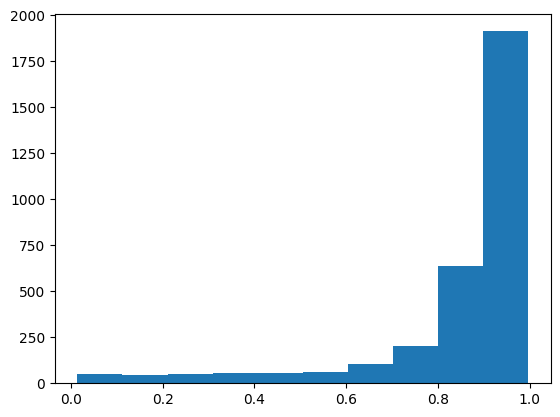

In [5]:
import matplotlib.pyplot as plt
len(pos_lst)
plt.hist(pos_lst)
plt.show()

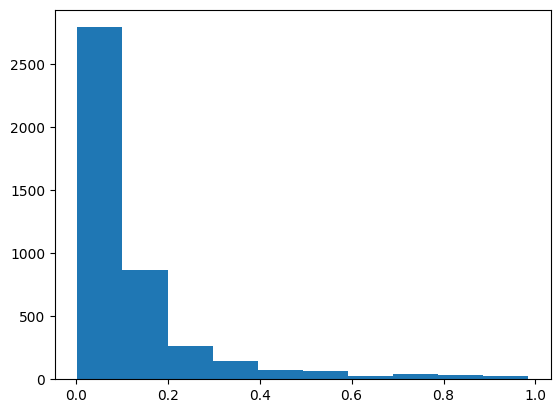

In [6]:
len(neg_lst)
plt.hist(neg_lst)
plt.show()

# Text -> Color

In [11]:
te = TextEncoder(
    token_num=45,
    max_seq_length=45,
    token_type_num=0,
    hidden_dim=128,
    intermediate_dim=128*4,
    head_num=8,
    block_num=6,
    drop_rate=0.1,
    ln_eps=1e-5
)
model = Text2Color.load_from_checkpoint(
    model_folder / 'Text2Color-epoch=25.ckpt',
    text_encoder = te
)
dm = TextColorDataModule(
    batch_size=10,
    train_path=train_aug_dir,
    valid_path=valid_dir,
    vocab_path=pathlib.Path('.').absolute(),
    max_text_length=45
)
dm.setup()

In [12]:
model = model.to('cpu')

torch.set_grad_enabled(False)
model.eval()
pos_lst = []
neg_lst = []

for idx in range(1500):
# for idx in random.choices(range(1500), k=10):
    text, target = dm.validation_dataset[idx]
    text['input_ids'] = text['input_ids'].to(model.device)
    text['attention_mask'] = text['attention_mask'].to(model.device)
    text['input_ids'] = text['input_ids'].unsqueeze(dim=0)
    text['attention_mask'] = text['attention_mask'].unsqueeze(dim=0)
    pred = model(text)
    pred = F.sigmoid(pred)
    # print('[%s]' % idx)
    # print('prediction:', pred)
    # print('target:', target)

    for i in torch.flatten(target * pred):
        if i > 0:
            pos_lst.append(i)
    for i in torch.flatten(torch.logical_not(target).int() * pred):
        if i > 0:
            neg_lst.append(i)

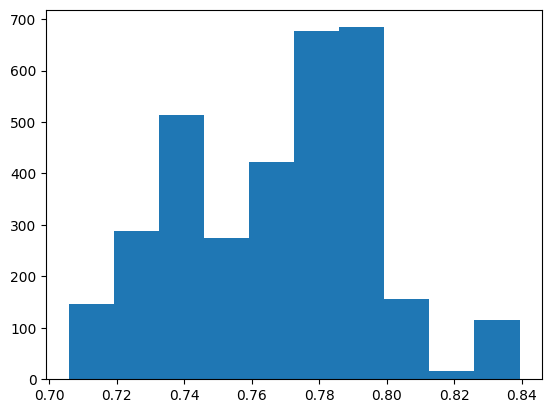

In [13]:
import matplotlib.pyplot as plt
len(pos_lst)
plt.hist(pos_lst)
plt.show()

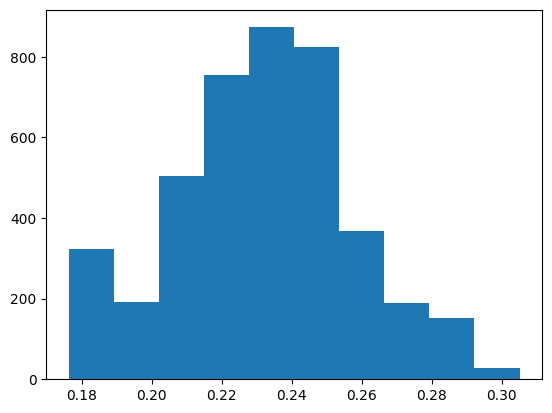

In [14]:
len(neg_lst)
plt.hist(neg_lst)
plt.show()

# Image -> Text

In [3]:
ie = ImageEncoder(
    input_resolution=256,
    patch_size=24,
    hidden_dim=128,
    intermediate_dim=128*4,
    head_num=8,
    block_num=8,
    drop_rate=0.1,
    ln_eps=1e-5
)
td = TextDecoder(
    token_num=45,
    max_seq_length=45,
    token_type_num=0,
    hidden_dim=128,
    intermediate_dim=128*4,
    head_num=8,
    block_num=8,
    drop_rate=0.1,
    ln_eps=1e-5,
    use_cache=True
)
model = Img2Text.load_from_checkpoint(
    model_folder / 'img2text/lr=0.0009, epoch=50/Img2Text-epoch=22.ckpt',
    img_encoder=ie,
    text_decoder=td
)
dm = ImgTextDataModule(
    batch_size=10,
    train_path=train_aug_dir,
    valid_path=valid_dir,
    vocab_path=pathlib.Path('.').absolute(),
    max_text_length=45
)
dm.setup()

In [4]:
model = model.to('cpu')

torch.set_grad_enabled(False)
model.eval()
lst = []

scene_all = pd.read_excel(dm.valid_path / 'scene.all.xlsx')

for idx in range(1500):
# for idx in random.choices(range(1500), k=10):
    img, text, target = dm.validation_dataset[idx]
    img = img.unsqueeze(dim=0)

    text = dm.validation_dataset.tokenizer(
        '[CLS]',
        add_special_tokens=False,
        return_tensors='pt'
    )

    text['input_ids'] = text['input_ids'].to(model.device)
    text['attention_mask'] = None
    # text['input_ids'] = text['input_ids'].unsqueeze(dim=0)
    # text['attention_mask'] = text['attention_mask'].unsqueeze(dim=0)

    pred = generator(ctx_img=img, 
                      ctx_text=text, 
                      tokenizer=dm.validation_dataset.tokenizer, 
                      model=model, 
                      post_process=postprocess_text, 
                      top_k=1, 
                      use_cache=True)
    # preds = generator(img, text, dm.validation_dataset.tokenizer, model, model.device)
    target = dm.validation_dataset.text[idx]

    max_len = max(len(pred), len(target))

    # preds = preds.ljust(max_len, ' ')
    # target = target.ljust(max_len, ' ')
    score = []
    score += [bleu_score(pred, [target], n_gram=1).item()]
    score += [bleu_score(pred, [target], n_gram=2).item()]
    score += [bleu_score(pred, [target], n_gram=3).item()]
    score += [bleu_score(pred, [target], n_gram=4).item()]

    # targets = generate_text_from_scene(idx, eval(scene_all.loc[idx]['scene']))
    # targets = map(lambda x: x.ljust(max_len, ' '), targets)
    # score = bleu_score(preds, targets, n_gram=4)
    # print(score.shape)
    # print(len(targets))
    # lst.append(len(targets))

    print(f'[{idx}]')
    print('점수:', score)
    print('예측 문장:', pred)
    print('원본 문장:', target)
    lst.append(score)

c:\Users\singbhang\Desktop\AI_Term\util\generate.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ctx_text['input_ids']),
c:\Users\singbhang\Desktop\AI_Term\util\generate.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ix),


[0]
점수: [0.6818181872367859, 0.5698028802871704, 0.4843646287918091, 0.3932836949825287]
예측 문장: 노랑 구은/는 검정 사각형의 오른쪽 위에 있다.; 검정 사각형은/는 빨강색 도넛의 아래쪽 뒤에 있다.; 빨강색 도넛은/는 노란 구의 왼쪽 위쪽 앞에 있다.
원본 문장: 노랑 동그라미은/는 검은색 상자의 오른쪽 위에 있다.; 검정 상자은/는 빨강 도넛의 아래쪽 뒤에 있다.; 빨간 도넛은/는 노랑 구의 왼쪽 위쪽 앞에 있다.
[1]
점수: [0.7727272510528564, 0.7177405953407288, 0.6567990779876709, 0.5877038240432739]
예측 문장: 초록 육면체은/는 검정 도넛의 오른쪽 뒤에 있다.; 검정 도넛은/는 파란 콘의 오른쪽 위쪽 앞에 있다.; 파란 원뿔은/는 초록색 육면체의 왼쪽 아래에 있다.
원본 문장: 녹색 육면체은/는 검정 도넛의 오른쪽 뒤에 있다.; 검정 도넛은/는 파랑 콘의 오른쪽 위쪽 앞에 있다.; 파랑 콘은/는 녹색 육면체의 왼쪽 아래에 있다.
[2]
점수: [0.6363636255264282, 0.3892494738101959, 0.0, 0.0]
예측 문장: 검정 원기둥은/는 노란 원기둥의 바로 밑에 있다.; 노란 원기둥은/는 빨강색 도넛의 왼쪽 앞에 있다.; 빨간 도넛은/는 검정 원기둥의 오른쪽 위쪽 뒤에 있다.
원본 문장: 노랑 동그란기둥은/는 검은색 원기둥의 바로 위에 있다.; 검은색 원기둥은/는 빨강 도넛의 왼쪽 아래 앞에 있다.; 빨강색 도넛은/는 노랑 원기둥의 오른쪽 뒤에 있다.
[3]
점수: [0.7142857313156128, 0.6546536684036255, 0.5877203345298767, 0.5100323557853699]
예측 문장: 빨강색 원기둥은/는 초록색 사각형의 왼쪽 아래에 있다.; 초록색 사각형은/는 빨간 도넛의 위쪽 앞에 있다.; 빨간 도넛은/는 빨강색 원기둥의 오른쪽 뒤에 있다.
원본 문장

KeyboardInterrupt: 

In [9]:
import numpy as np
# print('Average BLEU Score:', sum(lst) / len(lst))
print('Average BLEU Score:', np.array(lst).mean(axis=0))

Average BLEU Score: [0.67776675 0.54395439 0.44917657 0.33500637]


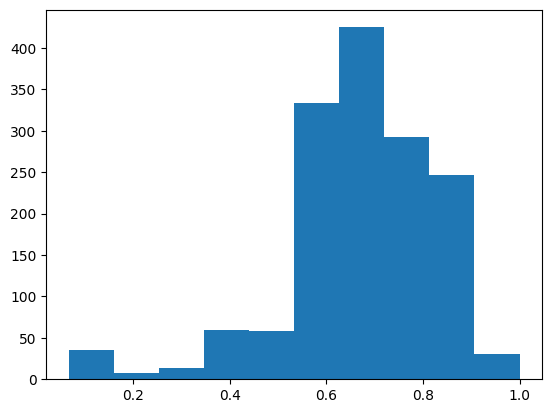

In [10]:
import matplotlib.pyplot as plt
plt.hist(np.array(lst).transpose()[0])
plt.show()

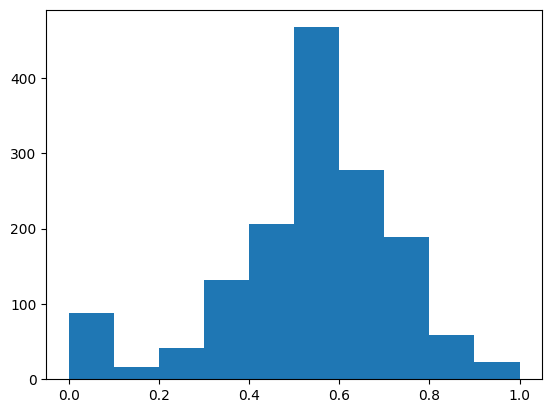

In [11]:
plt.hist(np.array(lst).transpose()[1])
plt.show()

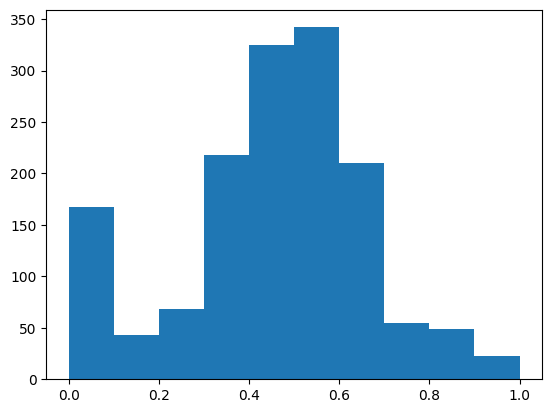

In [12]:
plt.hist(np.array(lst).transpose()[2])
plt.show()

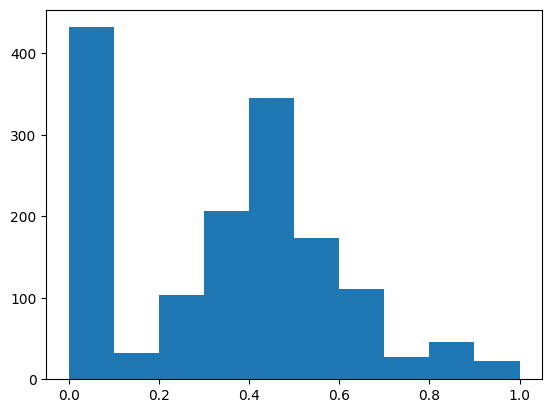

In [13]:
plt.hist(np.array(lst).transpose()[3])
plt.show()

# Image -> Graph

In [3]:
ie = ImageEncoder(
    input_resolution=256,
    patch_size=24,
    hidden_dim=128,
    intermediate_dim=128*4,
    head_num=8,
    block_num=8,
    drop_rate=0.1,
    ln_eps=1e-5
)
td = TextDecoder(
    token_num=57,
    max_seq_length=12,
    token_type_num=0,
    hidden_dim=128,
    intermediate_dim=128*4,
    head_num=8,
    block_num=8,
    drop_rate=0.1,
    ln_eps=1e-5,
    use_cache=True
)
model = Img2Graph.load_from_checkpoint(
    model_folder / 'img2graph/Img2Graph-epoch=29.ckpt',
    img_encoder=ie,
    text_decoder=td
)
dm = ImgGraphDataModule(
    batch_size=10,
    train_path=train_graph_aug_dir,
    valid_path=valid_dir,
    max_seq_length=12
)
dm.setup()

In [4]:
model = model.to('cpu')

torch.set_grad_enabled(False)
model.eval()
lst = []

scene_all = pd.read_excel(dm.valid_path / 'scene.all.xlsx')

for idx in range(1500):
# for idx in random.choices(range(1500), k=10):
    img, graph, target = dm.validation_dataset[idx]
    img = img.unsqueeze(dim=0)

    graph = {
        'input_ids': torch.tensor([[dm.validation_dataset.tokenizer.encode_token('[CLS]')]]).long(),
        'attention_mask': None
    }

    graph['input_ids'] = graph['input_ids'].to(model.device)
    graph['attention_mask'] = None
    # text['input_ids'] = text['input_ids'].unsqueeze(dim=0)
    # text['attention_mask'] = text['attention_mask'].unsqueeze(dim=0)

    pred = generator(ctx_img=img, 
                      ctx_text=graph, 
                      tokenizer=dm.validation_dataset.tokenizer, 
                      model=model, 
                      post_process=lambda x: x, 
                      top_k=1, 
                      use_cache=True,
                      decode=False)
    pred_graph = postprocess_graph(dm.validation_dataset.tokenizer.decode(pred))
    # preds = generator(img, text, dm.validation_dataset.tokenizer, model, model.device)
    target = eval(dm.validation_dataset.graph[idx])
    target_graph = target
    target = dm.validation_dataset.tokenizer.encode(target, add_special_tokens=True)['input_ids']

    pred = ' '.join(map(str,pred.tolist()))
    target = ' '.join(map(str,target))
    score = []
    score += [bleu_score(pred, [target], n_gram=1).item()]
    score += [bleu_score(pred, [target], n_gram=2).item()]
    score += [bleu_score(pred, [target], n_gram=3).item()]
    score += [bleu_score(pred, [target], n_gram=4).item()]

    print(f'[{idx}]')
    print('점수:', score)
    print('예측 문장:', pred)
    print('예측 그래프:', pred_graph)
    print('원본 문장:', target)
    print('원본 그래프:', target_graph)
    lst.append(score)

c:\Users\singbhang\Desktop\AI_Term\util\generate.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ctx_text['input_ids']),
c:\Users\singbhang\Desktop\AI_Term\util\generate.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ix),


[0]
점수: [0.7272727489471436, 0.0, 0.0, 0.0]
예측 문장: 2 20 19 48 19 8 37 8 20 43 3
예측 그래프: [((3, 'red'), (2, 'black'), ('Sx', 'F', 'T')), ((2, 'black'), (0, 'yellow'), ('L', 'Sy', 'U')), ((0, 'yellow'), (3, 'red'), ('R', 'B', 'U'))]
원본 문장: 2 8 19 45 19 20 52 20 8 30 3
원본 그래프: [((0, 'yellow'), (2, 'black'), ('R', 'Sy', 'T')), ((2, 'black'), (3, 'red'), ('Sx', 'B', 'U')), ((3, 'red'), (0, 'yellow'), ('L', 'F', 'T'))]
[1]
점수: [1.0, 1.0, 1.0, 1.0]
예측 문장: 2 17 24 44 24 26 39 26 17 37 3
예측 그래프: [((2, 'green'), (3, 'black'), ('R', 'B', 'Sz')), ((3, 'black'), (4, 'blue'), ('R', 'F', 'T')), ((4, 'blue'), (2, 'green'), ('L', 'Sy', 'U'))]
원본 문장: 2 17 24 44 24 26 39 26 17 37 3
원본 그래프: [((2, 'green'), (3, 'black'), ('R', 'B', 'Sz')), ((3, 'black'), (4, 'blue'), ('R', 'F', 'T')), ((4, 'blue'), (2, 'green'), ('L', 'Sy', 'U'))]
[2]
점수: [0.7272727489471436, 0.0, 0.0, 0.0]
예측 문장: 2 20 14 42 14 13 55 13 20 32 3
예측 그래프: [((3, 'red'), (1, 'black'), ('R', 'B', 'T')), ((1, 'black'), (1, 'yellow'), ('Sx', 'Sy', 

In [5]:
import numpy as np
# print('Average BLEU Score:', sum(lst) / len(lst))
print('Average BLEU Score:', np.array(lst).mean(axis=0))

Average BLEU Score: [0.86593806 0.44818112 0.39955319 0.36501145]


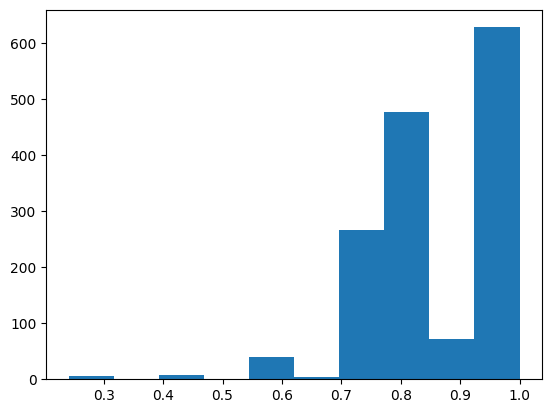

In [6]:
import matplotlib.pyplot as plt
plt.hist(np.array(lst).transpose()[0])
plt.show()

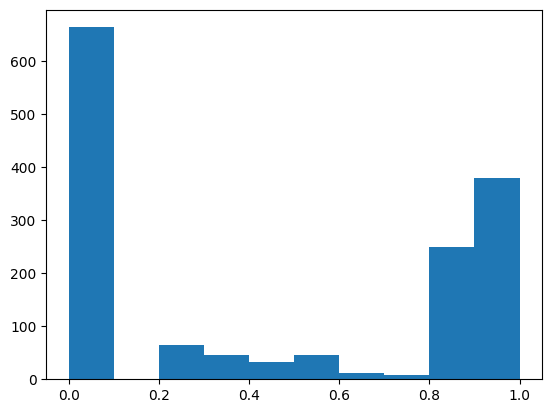

In [7]:
plt.hist(np.array(lst).transpose()[1])
plt.show()

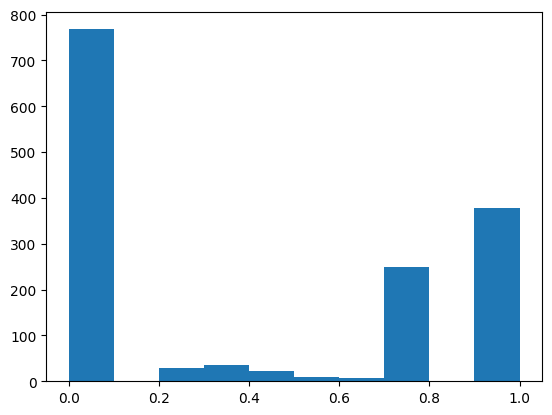

In [8]:
plt.hist(np.array(lst).transpose()[2])
plt.show()

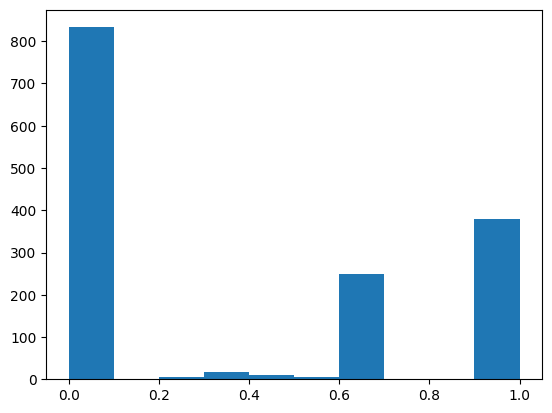

In [9]:
plt.hist(np.array(lst).transpose()[3])
plt.show()